# Detección de anomalías en señales de electroencefalogafía

## Introducción

En esta notebook se presenta una implementación de un método de detección de anomalías en series de tiempo basado en mapas auto-organizados (SOM: Self-organized Maps) como se describe en el artículo *Novelty Detection in Time Series Using Self-Organizing Neural Networks: A Comprehensive Evaluation*, Aguayo & Barreto (2018) aplicado a un conjunto de datos de señales de EEG. 

### Concepto de inmersión (embedding) de una serie de tiempo

Se denomina inmersión al proceso de transformación de una serie de tiempo hacia un espacio de dimensión $p$ mediante el desplazamiento de una ventana de dimensión $p$ a lo largo de la serie como se muestra en el siguiente ejemplo:


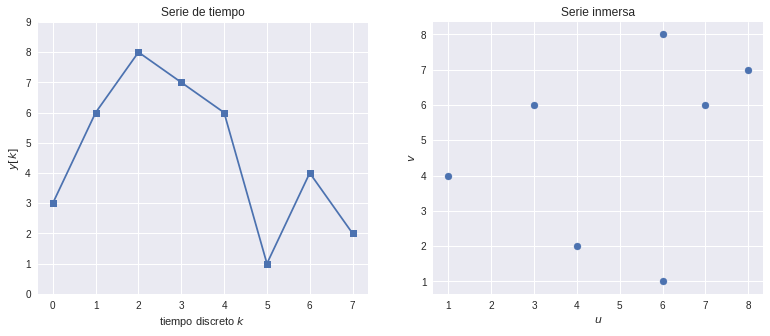

In [3]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

y = [3,6,8,7,6,1,4,2]

#------- Inmersión ----------
Yem = []
for k in range(len(y)-1):
    Yem.append([y[k],y[k+1]])
#----------------------------

fig,ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(y,'s-')
ax[0].set_ylim([0,9])
ax[0].set_xlabel("tiempo discreto $k$")
ax[0].set_ylabel("$y[k]$")
ax[0].set_title("Serie de tiempo")

ax[1].scatter(*list(zip(*Yem)))
ax[1].set_xlabel("$u$")
ax[1].set_ylabel("$v$")
ax[1].set_title("Serie inmersa")
plt.show()

En este ejemplo se ha transofrmado un conjunto de datos lineal a un espacio de dos dimensiones ($p=2$). Esta transformación nos permite aplicar métodos de detección de anomalías diseñados para espacios vectoriales $\mathbb{R}^n$.

## Mapa auto-organizado temporal

Un mapa auto-organizado (SOM por sus siglas en inglés) estándar es un tipo de red neuronal artificial entrenada usando aprendizaje no supervisado para producir una representación discreta del espacio de de entrada llamado mapa \[1\]. Este mapa está asociado a la distribución de las neuronas en la red. Los pesos de cada neurona representan una posición en el espacio de los datos de entrada. Cada neurona compite por encontrar el error más pequeño entre cada dato de entrenamiento y sus pesos. Los pesos se actualizan en función de una vecindidad al rededor de la neurona ganadora en la rejilla neuronal:

<img src="https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif" width="420" align="center">

Un mapa auto-organizado temporal es una variante que toma como entrada una memoria de retardos que realizan un proceso de inmersión de una serie de tiempo:

<img src="Temp_SOM.png" width="600" align="center">

El proceso de entrenamiento es el siguiente. Primero se calcula el **error de cuantización** entre un dato de entrada y todas las neuronas de $i$ hasta $Q$:

$$\boldsymbol{e}^q_i(k) = \boldsymbol{x}_m(k) - \boldsymbol{w}_i(k), \quad i=0,1,..., Q $$

Después se calculan los estados de activación donde $\lambda$ es un factor de escalamiento entre 0 y 1:

$$a_i(k) = \lambda a_i(k-1) - \frac{1}{2}||\boldsymbol{e}^q_i(k)||^2   $$

El índice de neurona ganadora se calcula como el índice del elemento del arreglo de activaciones que tiene el valor máximo:

$$i^* = arg\max_{\forall i}\{a_i(k)\} $$

La actualización de los pesos se realiza como:

$$\boldsymbol{w}_i(k+1) = \boldsymbol{w}_i(k) + \eta (k)H(i^*,i,k)\boldsymbol{e}^q_i(k) $$

dónde:
$$ \eta (k) = \eta_0(1-k/K),\quad H(i^*,i,k) = \exp{\left(-\frac{||\boldsymbol{r}_i-\boldsymbol{r}_{i^{*}}||^2}{\sigma^2 (k)}\right)}, \quad \sigma (k) = 2\sigma_0\exp{(-k/K)}$$

Los vectores $\boldsymbol{r}_i$ son las posiciones de la neurona en la rejilla neuronal.

### Implementación en Python

In [8]:
import numpy as np
import math
import numba

#---------- SOM Temporal -----------
@numba.jit(nopython=True)
def entrenar(W,X,a0 = 0.1,sig0 = 1.5):
    """
    Parámetros
    ----------
    W : Arreglo numpy de dobles
        Matriz de pesos.
    X : Arreglo numpy de dobles
        Serie de tiempo de entrenamiento.
    n : Entero escalar
        Número de época

    Returns
    -------
    W : Arreglo lineal de flotantes
        Matriz de pesos entrenada.
    """
    M,N,depth = W.shape
    Q = M*N 
    K = X.shape[0]-depth
    darray = np.zeros(Q) #array de distancias W[i],X[t]
    lmd = 0.2
    aa = np.zeros(Q) #array de activaciones pasadas
    
    def dot(X0,X1): #Producto punto (np.dot no soportado por numba)
        s = 0
        for i in range(X0.shape[0]):
            s += X0[i]*X1[i]
        return s
    
    for k in range(K): #iteración a lo largo de la serie
        
        x = X[k:k+depth] # ventana   
    
        for i in range(M): # Iteración sobre neuronas
            for j in range(N):
                #--- d[i]:(distancia(w,dato))
                e = math.sqrt(dot(x-W[i,j],x-W[i,j]))
                atm = lmd*aa[i*N+j] - 1/2*e
                darray[i*N+j] = atm
                aa[i*N+j] = atm
        iganadora = np.argmax(darray)
        
        #Actualización de pesos
        for i in range(M):
            for j in range(N):
                rw = np.array([iganadora%M,iganadora/N])
                ri = np.array([i%M,i/N])
                d = math.sqrt(dot(rw-ri,rw-ri)) 
                Hck = np.exp(-d/(2*(sig0*np.exp(-k/K))**2))
                a = a0*(1-k/K)
                W[i,j] += Hck*a*(x-W[i,j])
    return W
#----------------------------------------

## Datos de electroencefalografía

Los datos y documentación de los mismos fueron facilitados por Mariana Franklin ([@marianarf](https://github.com/marianarf)) y fueron obtenidos utilizado el headset [MUSE 2](https://choosemuse.com/muse-2/). Los datos se encuentran en [Estándar de Neurociencia Abierta](https://docs.google.com/document/d/1QzpmsojnnR2AkqqFXoCVqMAsCo54R9RhzmUjVa0fEFk/). 

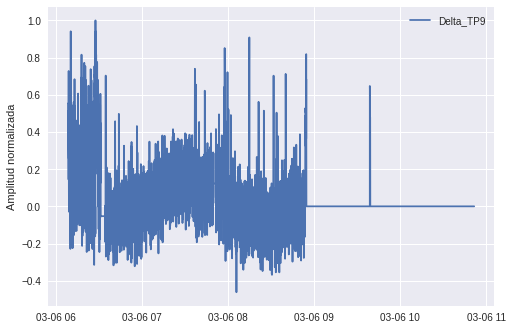

In [27]:
import pandas as pd

#--------------- EEG ------------------
#Carga de datos
df = pd.read_csv('mindMonitor_2020-03-06--06-08-22.csv',
                  parse_dates=['TimeStamp'],low_memory=False)

#Lista de nombres de columnas
cols = df.columns.values

#Eliminar filas con NaN en el campos 1:21
df.dropna(inplace=True,subset=cols[1:21])
#----------------------------------------

# Subset de trabajo: Onda Delta canal TP9
serieTiempo = df[cols[1]].values

# Normalizado de datos
serieTiempo = serieTiempo/serieTiempo.max()

x_dates = df[cols[0]].values
plt.plot(x_dates,serieTiempo,label=cols[1])
plt.ylabel("Amplitud normalizada")
plt.legend()
plt.show()

## Entrenamiento 

La red temporal será entrenada con las secuencias de inmersión de manera que los vectores del espacio de inmersión con mayor frecuencia de aparición serán asociados a las neuronas en la rejilla $M \times N$.

In [66]:
import time

#---------- Hyper-parámetros ----------
depth = 20 # Profundidad de ventana
M     = 10
N     = 10
Q     = M*N
EP    = 70
#---------------------------------

W     = np.random.rand(M,N,depth) # Matriz de pesos
start = time.time()
for n in range(EP):
    W = entrenar(W,serieTiempo,a0=1)
end = time.time()
print("Tiempo de entrenamiento:",end - start,"segundos")

Tiempo de entrenamiento: 151.3630018234253 segundos


### Gráfica de mapa de neuronas

La siguiente gráfica muestra los centroides de las 64 neuronas cada uno graficado en el tiempo discreto a lo largo de la profundidad de la memoria. Estos cenotrides pueden interpretarse como las 64 configuraciones más usuales a lo largo de la serie de tiempo. 

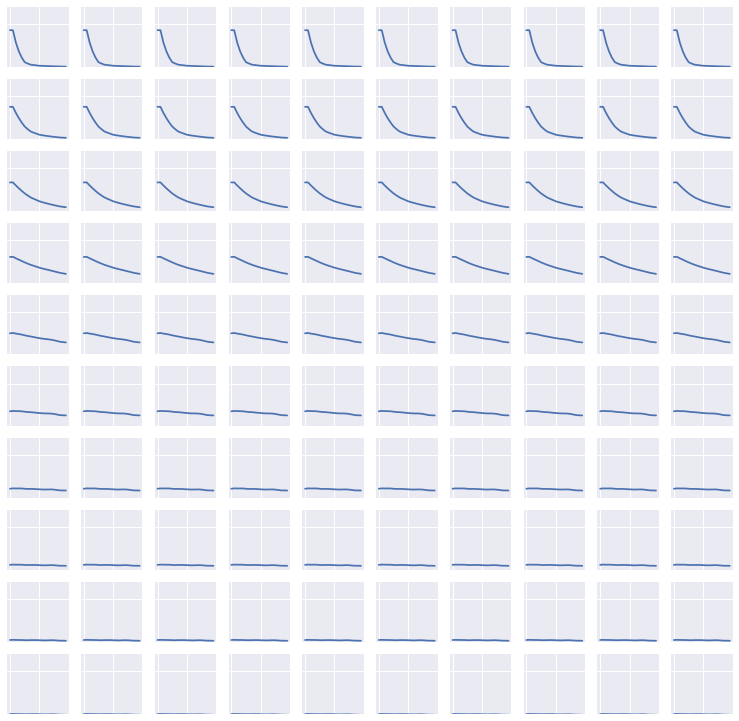

In [67]:
fig, ax2 = plt.subplots(M,N,figsize=(13,13))
for i in range(M):
    for j in range(N):
        ax2[i,j].plot(W[i,j])
        ax2[i,j].xaxis.set_ticklabels([])
        ax2[i,j].yaxis.set_ticklabels([])
        ax2[i,j].set_ylim(0,0.7)
plt.show()

## Detección de anomalías
Se utilizará ahora al error de quantización $e^q_{i^*}$ como una métrica de anomalía. Después de entrenar la red se realiza un último barrido en la serie para generar un registro de errores sin actualizar los pesos. El umbral en el error de cuantización como criterio de detección se establece como el percentil $100*(1-b/2)$. 

Tiempo de detección: 0.8799490928649902 segundos


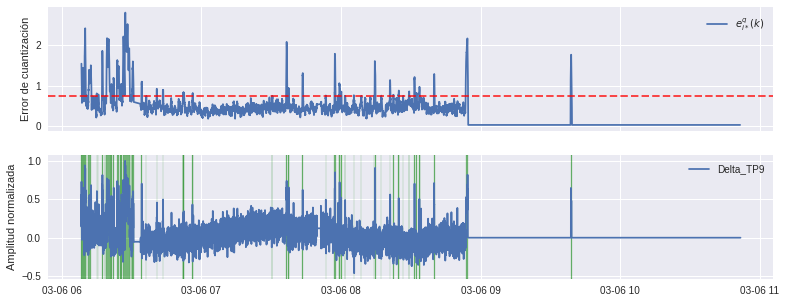

In [49]:
@numba.jit(nopython=True)
def qerror(W,X):
    """
    Parameters
    ----------
    W : Arreglo numpy (Double)
        Matriz de pesos.
    X : Arreglo numpy (Double)
        Objetos a clasificar

    Returns
    -------
    qerror : Arreglo numpy de dobles
             Error de cuantización
    """
    M,N,depth = W.shape
    darray = np.zeros(M*N) #array de distancias W[i],X[t]
    aarray = np.zeros(X.shape[0]-depth) #array de anomalias
    
    def dot(X0,X1): #Producto punto (np.dot no soportado por numba)
        s = 0
        for i in range(X0.shape[0]):
            s += X0[i]*X1[i]
        return s
    
    for k in range(X.shape[0]-depth): #iteración a lo largo de la serie
        x = X[k:k+depth] # ventana   
        for i in range(M): # Iteración sobre neuronas
            for j in range(N):
                #--- d[i]:(distancia(w,dato))
                darray[i*N+j] = math.sqrt(dot(x-W[i,j],x-W[i,j])) 
        
        aarray[k] = np.min(darray)
            
    return aarray

#---------- Detección de anomalías --------------
start = time.time()
an_array = qerror(W,serieTiempo)
end = time.time()
print("Tiempo de detección:",end-start,"segundos")
#-------------------------------------------------

#--------------- Gráficas ------------------------
fig, ax = plt.subplots(2,1,sharex=True,figsize=(13,5))
xx = df[cols[0]].values[int(depth/2):df.shape[0]-int(depth/2)]
xd = df[cols[0]].values


ax[0].plot(xx,an_array,label="$e^{q}_{i*}(k)$")
ax[0].set_ylabel("Error de cuantización")
ax[0].legend()

ax[1].plot(xd,serieTiempo,label=cols[1])
ax[1].set_ylabel("Amplitud normalizada")
ax[1].legend()

#--------- Umbral de detección ----------------
b = 0.15
threshold = np.percentile(an_array,100*(1-b/2))
#----------------------------------------------

ax[0].axhline(threshold, color='red',linestyle='--', lw=2, alpha=0.7)
ax[1].fill_between(xx, 0, 1, where=an_array > threshold,
                color='green', alpha=0.5, transform=ax[1].get_xaxis_transform())
plt.show()

### Segmentación de secuencias anómalas
Se crea un arreglo de datos con todas las secuencias anómalas para su análisis individual.

51 anomalías detectadas


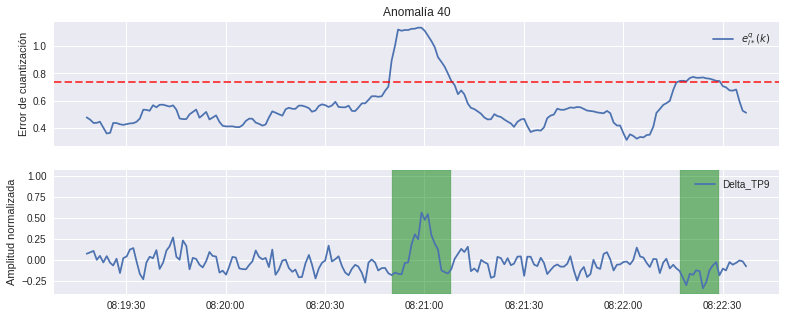

In [68]:
from scipy import signal

#Detección de picos
peaks = signal.find_peaks(an_array,height=threshold,distance = 40)
N = len(peaks[0])
print(N,'anomalías detectadas')

#Agrupación de secuencias anómalas
anom   = np.zeros([N,80])
y_anom = np.zeros([N,80])
for i in range(N):
    p = peaks[0][i]
    anom[i]   = an_array[p-40:p+40]
    y_anom[i] = serieTiempo[p-40+int(depth/2):p+40+int(depth/2)]

an_N = 40  
pico = peaks[0][an_N]

#--------------- Gráficas ------------------------
fig, ax  = plt.subplots(2,1,sharex=True,figsize=(13,5))
spn      = 100
x_dates  = df[cols[0]].values[pico-spn:pico+spn]
an_seg   = an_array[pico-spn:pico+spn]
segmento = serieTiempo[pico-spn+int(depth/2):pico+spn+int(depth/2)]

ax[0].plot(x_dates,an_seg,label="$e^{q}_{i*}(k)$")
ax[0].set_title("Anomalía "+str(an_N))
ax[0].set_ylabel("Error de cuantización")
ax[0].legend()

ax[1].plot(x_dates,segmento,label=cols[1])
ax[1].set_ylabel("Amplitud normalizada")
ax[1].legend()

ax[0].axhline(threshold, color='red',linestyle='--', lw=2, alpha=0.7)
ax[1].fill_between(x_dates, 0, 1, where=an_seg > threshold,
                color='green', alpha=0.5, transform=ax[1].get_xaxis_transform())
plt.show()

### Referencias
\[1\] *Self-organized formation of topologically correct feature maps*, Teuvo Kohonen (1982)